In [18]:
import pandas as pd
import numpy as np
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
from calc_pxp import bms 

sns.set_context('talk',font_scale=0.9)
save_plots=False

# Model recovery

### generating model — alpha = 0

In [32]:
gen_alpha_0_df = pd.DataFrame()
for sub in range(1,501):
    try:
        fit_alpha_0 = pd.read_csv("fit_data/gen_alpha_0_fit_alpha_0/neg_llh/sub"+str(sub)+".csv")

        fit_alpha_02 = pd.read_csv("fit_data/gen_alpha_0_fit_alpha_02/neg_llh/sub"+str(sub)+".csv")

        temp = pd.DataFrame({'sub_num':[sub]*2,'fit_model':['alpha_0','alpha_02'],'neg_llh':[fit_alpha_0.neg_llh[0],fit_alpha_02.neg_llh[0]]})
        gen_alpha_0_df = pd.concat([gen_alpha_0_df,temp])

    except:
        continue


In [33]:
gen_alpha_0_df=gen_alpha_0_df.reset_index(drop=True)
n_params=3
gen_alpha_0_df['AIC'] = 2*gen_alpha_0_df['neg_llh'] + 2*n_params
gen_alpha_0_df['sign_invert_AIC'] = -2*gen_alpha_0_df['AIC'] #https://mbb-team.github.io/VBA-toolbox/wiki/BMS-for-group-studies/#a-note-on-model-scores-vb-free-eneergy-aic-or-bic, multiply by -2 to invert the sign
min_inds = gen_alpha_0_df.groupby("sub_num", sort=False).AIC.idxmin()
result = gen_alpha_0_df.loc[min_inds]

n_subs = len(result)
n_subs_alpha_0=len(result.query("fit_model=='alpha_0'"))
n_subs_alpha_02=len(result.query("fit_model=='alpha_02'"))


alpha_0_subs = np.array([n_subs_alpha_0/n_subs, n_subs_alpha_02/n_subs])


### generating model -- alpha = 0.2

In [34]:
gen_alpha_02_df = pd.DataFrame() 
for sub in range(1,501):
    try:
        fit_alpha_0 = pd.read_csv("fit_data/gen_alpha_02_fit_alpha_0/neg_llh/sub"+str(sub)+".csv")

        fit_alpha_02 = pd.read_csv("fit_data/gen_alpha_02_fit_alpha_02/neg_llh/sub"+str(sub)+".csv")

        temp = pd.DataFrame({'sub_num':[sub]*2,'fit_model':['alpha_0','alpha_02'],'neg_llh':[fit_alpha_0.neg_llh[0],fit_alpha_02.neg_llh[0]]})
        gen_alpha_02_df = pd.concat([gen_alpha_02_df,temp])

    except:
        continue

In [35]:
gen_alpha_02_df=gen_alpha_02_df.reset_index(drop=True)
n_params=4
gen_alpha_02_df['AIC'] = 2*gen_alpha_02_df['neg_llh'] + 2*n_params
gen_alpha_02_df['sign_invert_AIC'] = -2*gen_alpha_02_df['AIC'] #https://mbb-team.github.io/VBA-toolbox/wiki/BMS-for-group-studies/#a-note-on-model-scores-vb-free-eneergy-aic-or-bic, multiply by -2 to invert the sign
min_inds = gen_alpha_02_df.groupby("sub_num", sort=False).AIC.idxmin()
result = gen_alpha_02_df.loc[min_inds]

In [36]:
n_subs = len(result)
n_subs_alpha_0=len(result.query("fit_model=='alpha_0'"))
n_subs_alpha_02=len(result.query("fit_model=='alpha_02'"))

alpha_02_subs = np.array([n_subs_alpha_0/n_subs, n_subs_alpha_02/n_subs])


### confusion matrix -- AIC

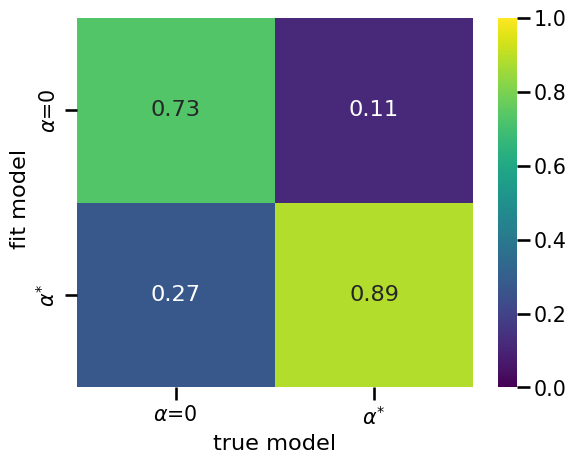

In [37]:
all_subs=np.transpose(np.array([alpha_0_subs,alpha_02_subs]))
labels=[r'$\alpha$=0',r'$\alpha^{*}$']
g=sns.heatmap(all_subs,cmap="viridis",annot=True,vmin=0,vmax=1)
g.set_xlabel("true model")
g.set_xticklabels(labels)
g.set_yticklabels(labels)
g.set_ylabel(" fit model")
if save_plots:
    plt.savefig('alpha_0_02_model_recov_proportions.png',bbox_inches = "tight",dpi=300,transparent=True)



### confusion matrix -- protected exceedance probabilities 

In [38]:
def return_pxp(age_group_df):
    age_group_df=age_group_df[['sub_num','fit_model','sign_invert_AIC']].groupby(by=["sub_num","fit_model"]).mean().reset_index()
    llh = age_group_df.pivot(index='sub_num', columns='fit_model', values='sign_invert_AIC').to_numpy()
    _,_,_,pxp,_,_=bms(llh)

    return pxp

gen_alpha_0_pxp = return_pxp(gen_alpha_0_df)
gen_alpha_02_pxp = return_pxp(gen_alpha_02_df)

data = np.squeeze(np.array([gen_alpha_0_pxp,gen_alpha_02_pxp]))

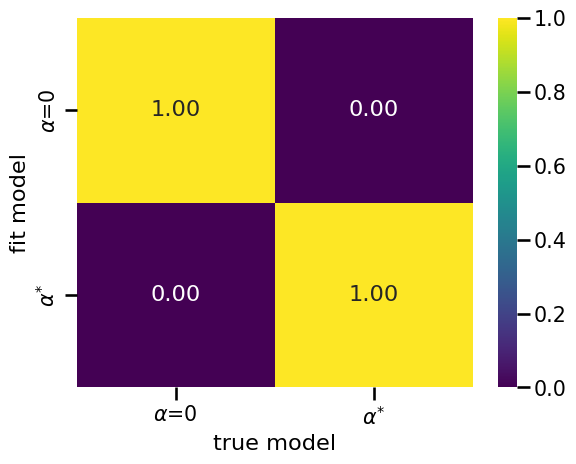

In [39]:
ax = sns.heatmap(data, annot=True, cmap="viridis", vmin=0, vmax=1, fmt='.2f')

labels = [r'$\alpha$=0',r'$\alpha^{*}$']
ax.set_yticklabels([r'$\alpha$=0',r'$\alpha^{*}$'])
ax.set_xlabel("true model")
ax.set_ylabel("fit model")
ax.set_xticklabels([r'$\alpha$=0',r'$\alpha^{*}$'])
if save_plots:
    plt.savefig('plots/alpha_0_02_model_recov_pxp.png',bbox_inches = "tight",dpi=300,transparent=True)


# Parameter recovery 

### generating model -  alpha = 0.2

In [22]:
alpha_02_params = pd.DataFrame()
for sub in range(1,501):
    try:
        gen_alpha_02 = pd.read_csv("gen_data/alpha_02.csv").query("sub_id==@sub").reset_index().loc()[0]
        gen_gamma_base = gen_alpha_02.gamma_base
        gen_gamma_coef = gen_alpha_02.gamma_coef
        gen_beta = gen_alpha_02.beta
        gen_epsilon = gen_alpha_02.epsilon


        fit_alpha_02 = pd.read_csv("fit_data/gen_alpha_02_fit_alpha_02/neg_llh/sub"+str(sub)+".csv")
        fit_gamma_base = fit_alpha_02.gamma_base[0]
        fit_gamma_coef = fit_alpha_02.gamma_coef[0]
        fit_beta  = fit_alpha_02.beta[0]
        fit_epsilon = fit_alpha_02.epsilon[0]
        
        temp = pd.DataFrame({'sub_num':[sub],'gen_gamma_base':gen_gamma_base,'gen_gamma_coef':gen_gamma_coef,'gen_beta':gen_beta, 'gen_epsilon':gen_epsilon,
                             'fit_gamma_base':fit_gamma_base,'fit_gamma_coef':fit_gamma_coef,'fit_beta':fit_beta, 'fit_epsilon':fit_epsilon},index=[0])
        alpha_02_params = pd.concat([alpha_02_params,temp])

    except:
        continue

            n         r         CI95%          p-val  power
spearman  500  0.776414  [0.74, 0.81]  6.466422e-102    1.0


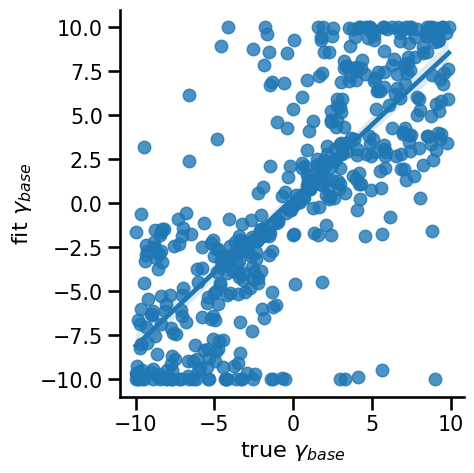

In [24]:
sns.lmplot(x="gen_gamma_base",y="fit_gamma_base",data=alpha_02_params)
plt.ylabel(r'fit $\gamma_{base}$')
plt.xlabel(r'true $\gamma_{base}$')
if save_plots:
    plt.savefig('plots/alpha_02_recov_gamma_base.png',bbox_inches = "tight",dpi=300,transparent=True)
print(pg.corr(alpha_02_params['gen_gamma_base'],alpha_02_params['fit_gamma_base'],method='spearman'))


            n         r         CI95%         p-val  power
spearman  500  0.677315  [0.63, 0.72]  2.168882e-68    1.0


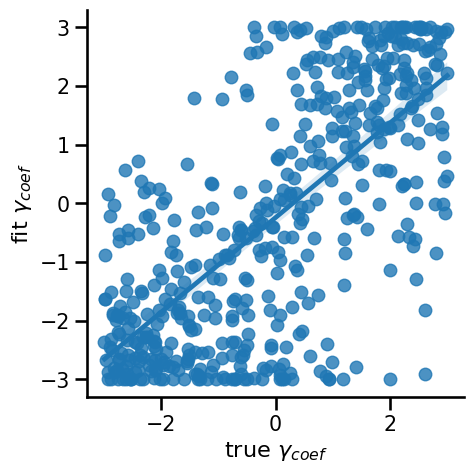

In [25]:
sns.lmplot(x="gen_gamma_coef",y="fit_gamma_coef",data=alpha_02_params)
plt.ylabel(r'fit $\gamma_{coef}$')
plt.xlabel(r'true $\gamma_{coef}$')
if save_plots:
    plt.savefig('plots/alpha_02_recov_gamma_coef.png',bbox_inches = "tight",dpi=300,transparent=True)
print(pg.corr(alpha_02_params['gen_gamma_coef'],alpha_02_params['fit_gamma_coef'],method='spearman'))

            n         r         CI95%         p-val  power
spearman  500  0.644528  [0.59, 0.69]  4.869158e-60    1.0


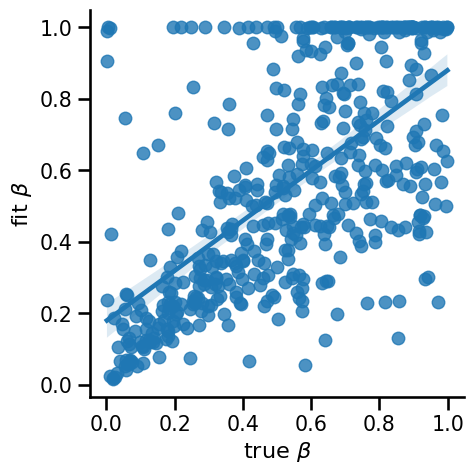

In [26]:
sns.lmplot(x="gen_beta",y="fit_beta",data=alpha_02_params)
plt.ylabel(r'fit $\beta$')
plt.xlabel(r'true $\beta$')
if save_plots:
    plt.savefig('plots/alpha_02_recov_beta.png',bbox_inches = "tight",dpi=300,transparent=True)
print(pg.corr(alpha_02_params['gen_beta'],alpha_02_params['fit_beta'],method='spearman'))

            n        r         CI95%         p-val  power
spearman  500  0.63783  [0.58, 0.69]  1.858909e-58    1.0


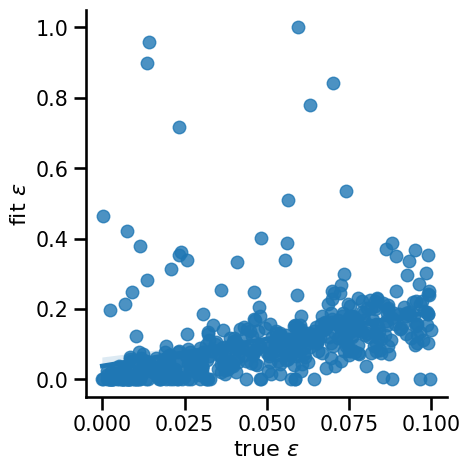

In [27]:
sns.lmplot(x="gen_epsilon",y="fit_epsilon",data=alpha_02_params)
plt.ylabel(r'fit $\epsilon$')
plt.xlabel(r'true $\epsilon$')
if save_plots:
    plt.savefig('plots/alpha_02_recov_epsilon.png',bbox_inches = "tight",dpi=300,transparent=True)
print(pg.corr(alpha_02_params['gen_epsilon'],alpha_02_params['fit_epsilon'],method='spearman'))

### generating model -  alpha = 0

In [28]:
alpha_0_params = pd.DataFrame()
for sub in range(1,501):
    try:
        
        gen_alpha_0 = pd.read_csv("gen_data/alpha_0.csv").query("sub_id==@sub").reset_index().loc()[0]
        gen_gamma_base = gen_alpha_0.gamma_base
        gen_gamma_coef = gen_alpha_0.gamma_coef
        gen_beta = gen_alpha_0.beta
        gen_epsilon = gen_alpha_0.epsilon


        fit_alpha_0 = pd.read_csv("fit_data/gen_alpha_0_fit_alpha_0/neg_llh/sub"+str(sub)+".csv")
        fit_gamma_base = fit_alpha_0.gamma_base[0]
        fit_gamma_coef = fit_alpha_0.gamma_coef[0]
        fit_beta  = fit_alpha_0.beta[0]
        fit_epsilon = fit_alpha_0.epsilon[0]
        
        temp = pd.DataFrame({'sub_num':[sub],'gen_gamma_base':gen_gamma_base,'gen_gamma_coef':gen_gamma_coef,'gen_beta':gen_beta, 'gen_epsilon':gen_epsilon,
                             'fit_gamma_base':fit_gamma_base,'fit_gamma_coef':fit_gamma_coef,'fit_beta':fit_beta, 'fit_epsilon':fit_epsilon},index=[0])
        alpha_0_params = pd.concat([alpha_0_params,temp])

    except:
        continue


            n         r         CI95%          p-val  power
spearman  500  0.852205  [0.83, 0.87]  3.327044e-142    1.0


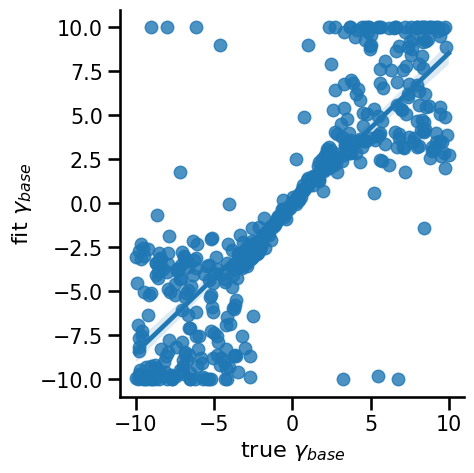

In [29]:
sns.lmplot(x="gen_gamma_base",y="fit_gamma_base",data=alpha_0_params)
plt.ylabel(r'fit $\gamma_{base}$')
plt.xlabel(r'true $\gamma_{base}$')
if save_plots:
    plt.savefig('plots/alpha_0_recov_gamma_base.png',bbox_inches = "tight",dpi=300,transparent=True)
print(pg.corr(alpha_0_params['gen_gamma_base'],alpha_0_params['fit_gamma_base'],method='spearman'))

            n         r         CI95%         p-val  power
spearman  500  0.736246  [0.69, 0.77]  1.686635e-86    1.0


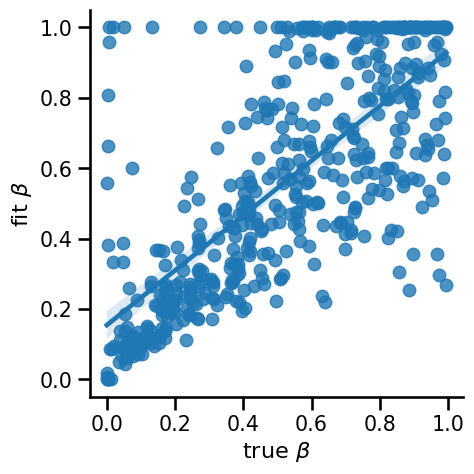

In [30]:
sns.lmplot(x="gen_beta",y="fit_beta",data=alpha_0_params)
plt.ylabel(r'fit $\beta$')
plt.xlabel(r'true $\beta$')
if save_plots:
    plt.savefig('plots/alpha_0_recov_beta.png',bbox_inches = "tight",dpi=300,transparent=True)
print(pg.corr(alpha_0_params['gen_beta'],alpha_0_params['fit_beta'],method='spearman'))

            n        r         CI95%         p-val  power
spearman  500  0.66121  [0.61, 0.71]  3.716636e-64    1.0


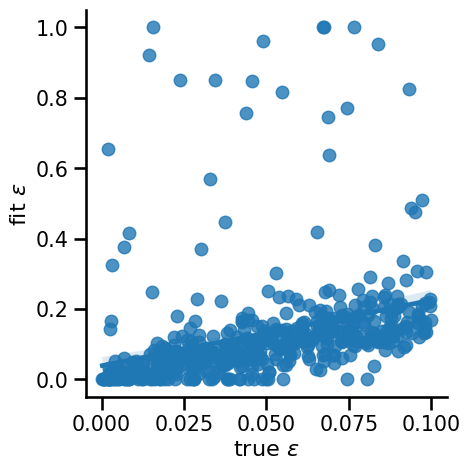

In [31]:
sns.lmplot(x="gen_epsilon",y="fit_epsilon",data=alpha_0_params)
plt.ylabel(r'fit $\epsilon$')
plt.xlabel(r'true $\epsilon$')
if save_plots:
    plt.savefig('plots/alpha_0_recov_epsilon.png',bbox_inches = "tight",dpi=300,transparent=True)
print(pg.corr(alpha_0_params['gen_epsilon'],alpha_0_params['fit_epsilon'],method='spearman'))